##GCP Setup and Titanic Dataset EDA

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Google from Colab
from google.colab import auth  # type: ignore
auth.authenticate_user()

# Set your GCP project ID
PROJECT_ID = "upbeat-aspect-471118-v8"
print("Using project:", PROJECT_ID)

Using project: upbeat-aspect-471118-v8


In [4]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# Optional: list datasets to verify access
list(client.list_datasets())

In [80]:
import seaborn as sns
import pandas as pd

# Load the Titanic dataset
titanic_df = pd.read_csv('Titanic.csv')

# Display the first few rows to confirm it's loaded
display(titanic_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [81]:
# Count the number of null values per column
missing_values = titanic_df.isnull().sum()

# Display the results
print("--- Missing values per column before dropping Embarked NaNs ---")
print(missing_values)

# Drop rows where 'Embarked' is null
titanic_df.dropna(subset=['Embarked'], inplace=True)

# Count the number of null values per column after dropping Embarked NaNs
missing_values_after_drop_embarked = titanic_df.isnull().sum()
print("\n--- Missing values per column after dropping Embarked NaNs ---")
print(missing_values_after_drop_embarked)

--- Missing values per column before dropping Embarked NaNs ---
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

--- Missing values per column after dropping Embarked NaNs ---
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


# Task
Load the "titanic.csv" dataset into a dataframe, display the info and descriptive statistics, count the null values for each column, impute the missing 'age' values using a regression model, and drop the 'deck' column.

## Data preparation for age imputation

### Subtask:
Select relevant features from the `titanic_df` that can be used to predict 'age' and separate the data into rows with and without missing 'age' values.


**Reasoning**:
Create two dataframes, one with non-null age values and one with null age values, then select the relevant features and target for training and testing.



In [82]:
df_not_null_age = titanic_df[titanic_df['Age'].notnull()].copy()
df_null_age = titanic_df[titanic_df['Age'].isnull()].copy()

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

X_train = df_not_null_age[features]
y_train = df_not_null_age['Age']

X_test = df_null_age[features]

## Build and train regression model

### Subtask:
Choose a suitable regression model (e.g., Linear Regression, RandomForestRegressor) and train it on the data with known 'age' values.


**Reasoning**:
Train a RandomForestRegressor model on the training data to predict age.



In [83]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['Sex', 'Embarked', 'Pclass']
numerical_features = ['SibSp', 'Parch', 'Fare']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

model = RandomForestRegressor(random_state=42)
model.fit(X_train_encoded, y_train)

RandomForestRegressor(random_state=42)

## Impute missing age values

### Subtask:
Use the trained regression model to predict the 'age' for the rows where it is missing.


**Reasoning**:
Use the trained model to predict the missing 'age' values in the encoded test data.



In [84]:
predicted_ages = model.predict(X_test_encoded)

## Combine data

### Subtask:
Merge the imputed 'age' values back into the original DataFrame.


**Reasoning**:
Assign the predicted ages to the DataFrame with missing ages and then concatenate it with the DataFrame that had no missing ages to form the complete dataset.



In [85]:
df_null_age['Age'] = predicted_ages
titanic_df = pd.concat([df_not_null_age, df_null_age], ignore_index=True)

## Drop 'Cabin' column

### Subtask:
Remove the 'Cabin' column from the DataFrame.


**Reasoning**:
Remove the 'Cabin' column from the DataFrame as instructed.



In [100]:
titanic_df.drop('Cabin', axis=1, inplace=True)
display(titanic_df.head())

KeyError: "['Cabin'] not found in axis"

## Verify changes

### Subtask:
Check the number of missing values again to confirm that 'age' has been imputed and 'deck' has been dropped.


**Reasoning**:
Check the number of missing values per column to confirm that 'age' has been imputed and 'deck' has been dropped.



In [89]:
missing_values_after = titanic_df.isnull().sum()
print("--- Missing values per column after imputation and dropping 'deck' ---")
print(missing_values_after)

--- Missing values per column after imputation and dropping 'deck' ---
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [90]:
# Display information about the DataFrame
print("--- DataFrame Info ---")
titanic_df.info()

# Display descriptive statistics
print("\n--- Descriptive Statistics ---")
display(titanic_df.describe())

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.5+ KB

--- Descriptive Statistics ---


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,29.502629,0.524184,0.382452,32.096681
std,256.998173,0.486260,0.834700,13.731377,1.103705,0.806761,49.697504
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Exploratory Data Analysis (EDA)

Now that the data has been cleaned, let's perform some more EDA to understand the distributions and relationships within the dataset.

### Distribution of Numerical Features

Let's visualize the distributions of the numerical features using histograms.

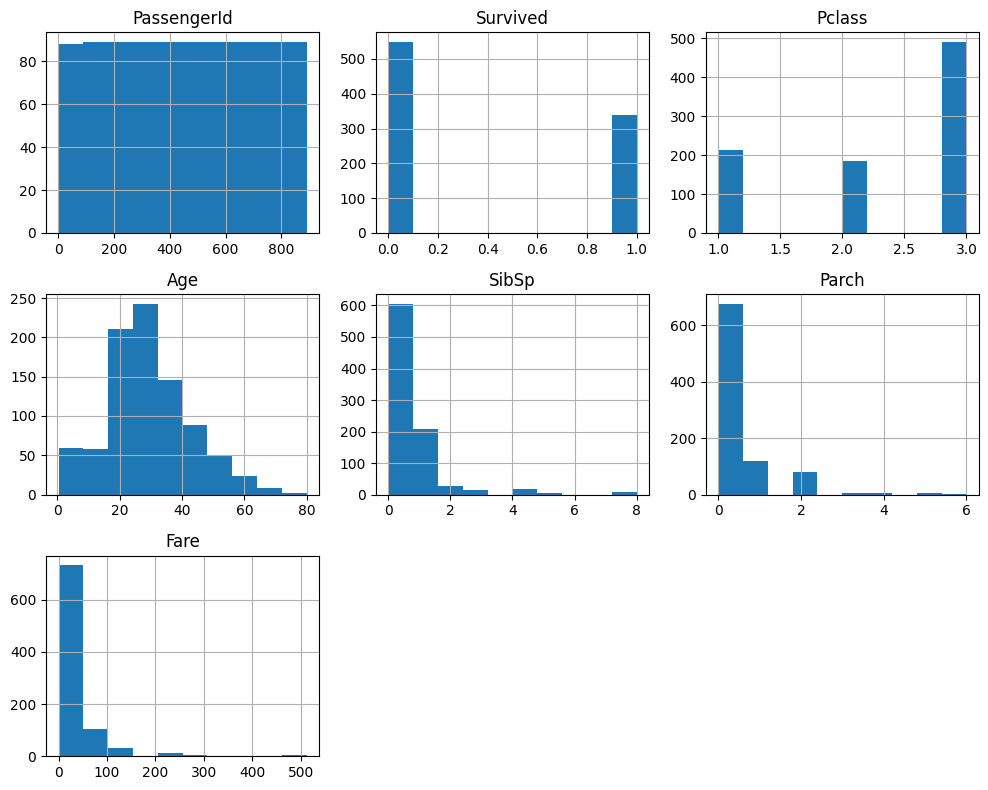

In [91]:
# Select numerical columns
numerical_cols = titanic_df.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for numerical features
titanic_df[numerical_cols].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

### Distribution of Categorical Features

Now, let's look at the distributions of the categorical features using count plots.

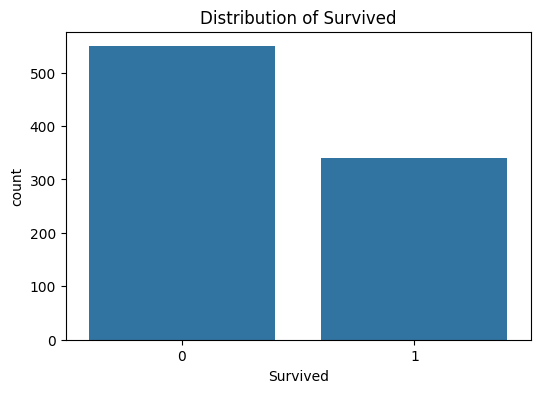

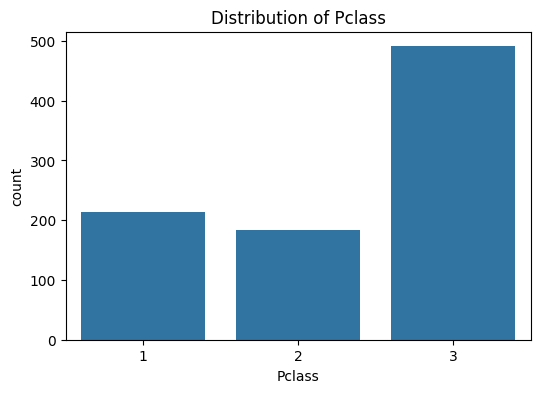

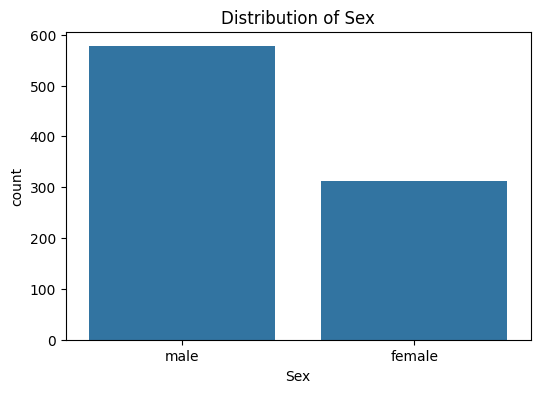

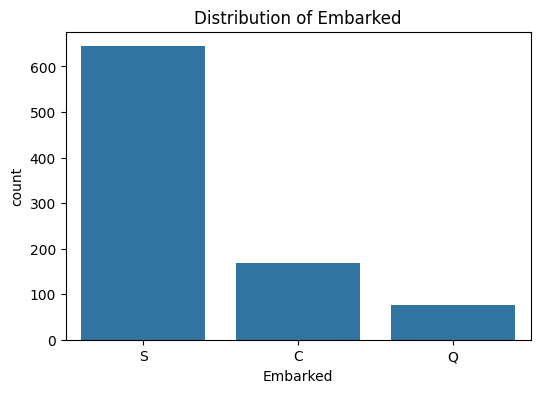

In [92]:
# Select categorical columns (excluding 'Name' and 'Ticket' as they have too many unique values)
categorical_cols = ['Survived', 'Pclass', 'Sex', 'Embarked']

# Plot count plots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=titanic_df)
    plt.title(f'Distribution of {col}')
    plt.show()

### Correlation Matrix

Let's visualize the correlation matrix for the numerical features to see the relationships between them.

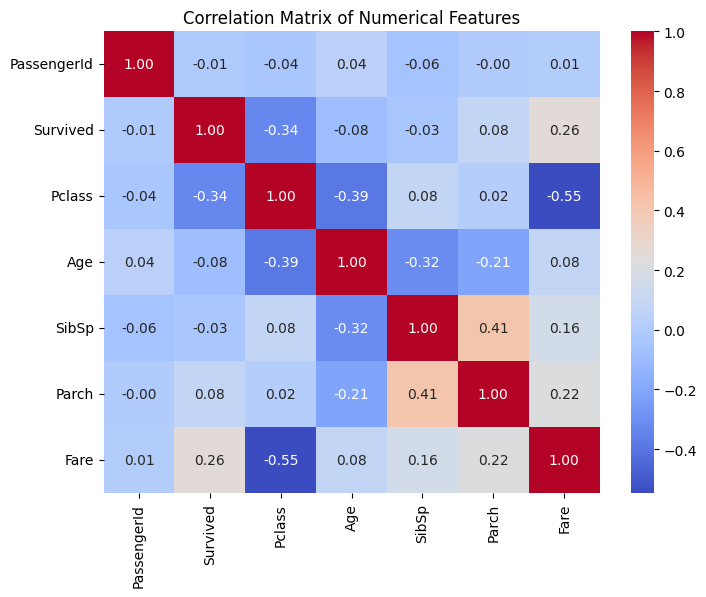

In [93]:
# Calculate the correlation matrix
correlation_matrix = titanic_df[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Task
Analyze and visualize the survival rates of passengers in the Titanic dataset based on gender, age, and passenger class, providing in-depth charts and summarizing key insights.

## Survival rate by gender

### Subtask:
Create a bar plot showing the survival rate for each gender.


**Reasoning**:
Calculate the survival rate by gender and create a bar plot to visualize it.



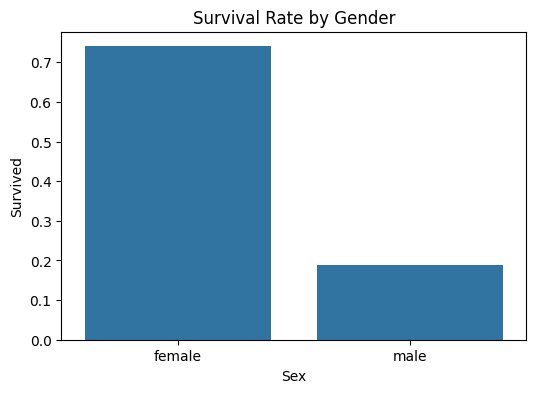

In [94]:
survival_rate_by_gender = titanic_df.groupby('Sex')['Survived'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=survival_rate_by_gender)
plt.title('Survival Rate by Gender')
plt.show()

## Survival rate by class

### Subtask:
Create a bar plot showing the survival rate for each passenger class.


**Reasoning**:
Group the DataFrame by 'Pclass', calculate the mean of 'Survived', reset the index, and create a bar plot to visualize the survival rate by passenger class.



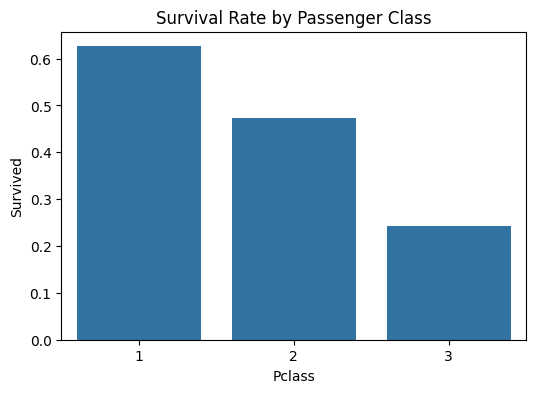

In [95]:
survival_rate_by_pclass = titanic_df.groupby('Pclass')['Survived'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', data=survival_rate_by_pclass)
plt.title('Survival Rate by Passenger Class')
plt.show()

## Survival rate by age group

### Subtask:
Categorize age into groups and create a bar plot showing the survival rate for each age group.


**Reasoning**:
Define age bins and labels, create a new column for age groups, calculate survival rate by age group, and create a bar plot to visualize the survival rate for each age group.



/tmp/ipython-input-4226092929.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_rate_by_age_group = titanic_df.groupby('AgeGroup')['Survived'].mean().reset_index()


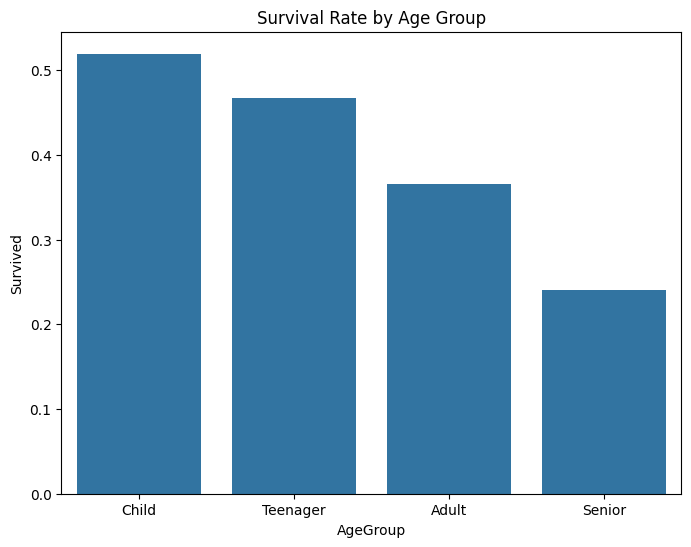

In [96]:
age_bins = [0, 12, 18, 60, 100]
age_labels = ['Child', 'Teenager', 'Adult', 'Senior']

titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins=age_bins, labels=age_labels, right=False)

survival_rate_by_age_group = titanic_df.groupby('AgeGroup')['Survived'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='AgeGroup', y='Survived', data=survival_rate_by_age_group)
plt.title('Survival Rate by Age Group')
plt.show()

## Survival rate by gender and class

### Subtask:
Create a grouped bar plot or a facet grid to visualize the survival rate by both gender and class.


**Reasoning**:
Create a grouped bar plot to visualize the survival rate by both passenger class and gender.



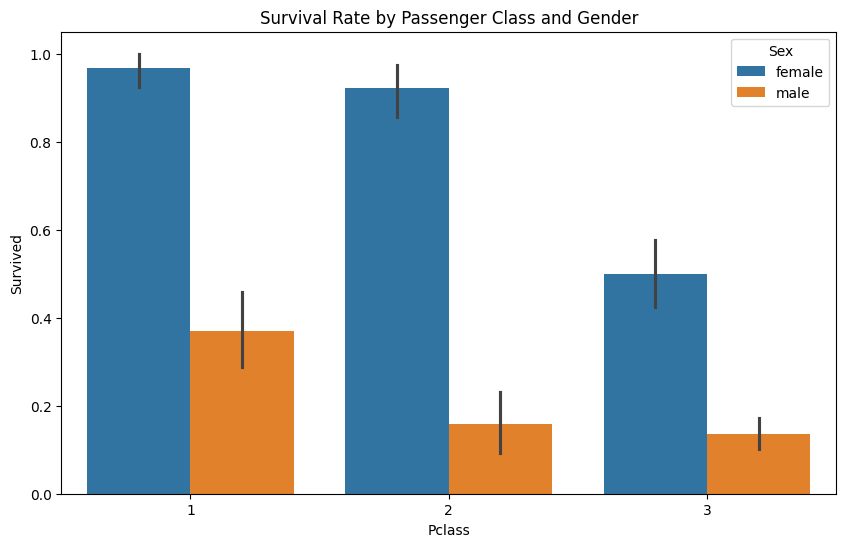

In [97]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)
plt.title('Survival Rate by Passenger Class and Gender')
plt.show()

## Survival rate by age and class

### Subtask:
Create a visualization (e.g., box plot or violin plot) to show the distribution of age for survived and not survived passengers within each class.


**Reasoning**:
Create a box plot to visualize the distribution of age for survived and not survived passengers within each class.



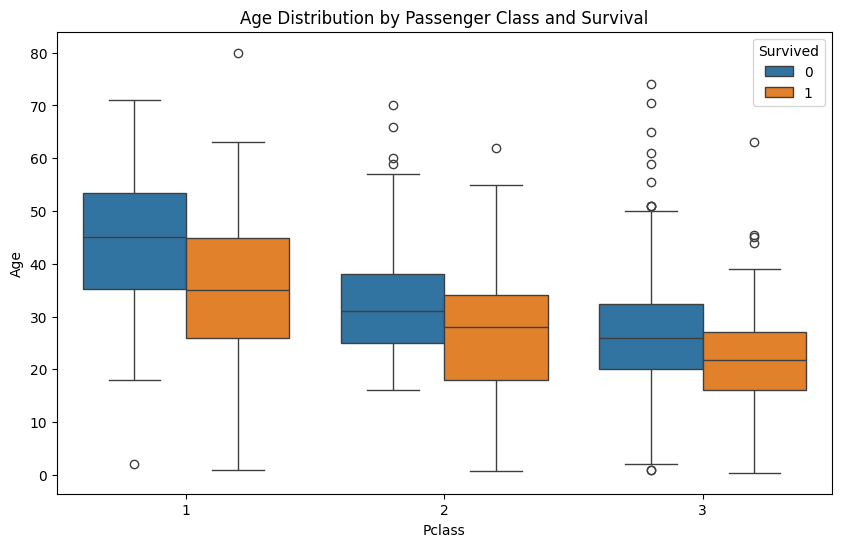

In [98]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', hue='Survived', data=titanic_df)
plt.title('Age Distribution by Passenger Class and Survival')
plt.show()

## Survival rate by age and gender

### Subtask:
Create a visualization to show the distribution of age for survived and not survived passengers within each gender.


**Reasoning**:
Generate a box plot to visualize the distribution of age for survived and not survived passengers within each gender.



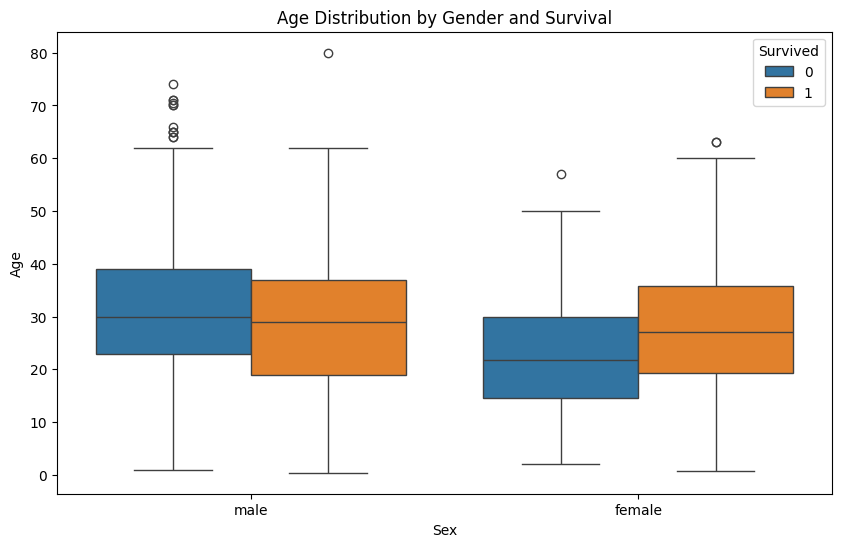

In [99]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='Age', hue='Survived', data=titanic_df)
plt.title('Age Distribution by Gender and Survival')
plt.show()

## Interactive Visualizations with Plotly

Let's create some interactive plots using Plotly to explore the survival rates.

### Survival Rate by Gender (Interactive)

In [101]:
import plotly.express as px

survival_rate_by_gender = titanic_df.groupby('Sex')['Survived'].mean().reset_index()

fig = px.bar(survival_rate_by_gender, x='Sex', y='Survived', title='Survival Rate by Gender (Interactive)')
fig.show()

### Survival Rate by Class (Interactive)

In [102]:
survival_rate_by_pclass = titanic_df.groupby('Pclass')['Survived'].mean().reset_index()

fig = px.bar(survival_rate_by_pclass, x='Pclass', y='Survived', title='Survival Rate by Passenger Class (Interactive)')
fig.show()

### Survival Rate by Age Group (Interactive)

In [104]:
# Ensure AgeGroup is a categorical type for correct ordering in Plotly
titanic_df['AgeGroup'] = pd.Categorical(titanic_df['AgeGroup'], categories=age_labels, ordered=True)

survival_rate_by_age_group = titanic_df.groupby('AgeGroup')['Survived'].mean().reset_index()

fig = px.bar(survival_rate_by_age_group, x='AgeGroup', y='Survived', title='Survival Rate by Age Group (Interactive)')
fig.show()

/tmp/ipython-input-651347831.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Summary:

### Data Analysis Key Findings

*   There is a significant disparity in survival rates between genders, with females having a substantially higher survival rate compared to males.
*   Passenger class played a crucial role in survival, with First Class passengers having the highest survival rate, followed by Second Class, and then Third Class.
*   Children generally had a higher survival rate than adults and seniors.
*   The combined effect of gender and class shows that being female and/or being in a higher passenger class significantly increased a passenger's likelihood of surviving.
*   Gender and passenger class were the most dominant factors influencing survival, while age also played a contributing role.

### Insights or Next Steps

*   The "women and children first" protocol and socioeconomic status appear to be strong determinants of survival in the Titanic disaster.
*   Further analysis could explore the interaction effects between age, gender, and class in more detail, perhaps using statistical models.


## Statistical Analysis of Survival Rate by Gender within Each Class

Let's use a statistical test to see if the difference in survival rates between genders is statistically significant within each passenger class. We can use the Chi-Squared test for independence.

In [105]:
from scipy.stats import chi2_contingency

# Analyze survival rate by gender for each class
for pclass in sorted(titanic_df['Pclass'].unique()):
    print(f"\n--- Analyzing Pclass {pclass} ---")
    df_class = titanic_df[titanic_df['Pclass'] == pclass]

    # Create a contingency table of Sex and Survived
    contingency_table = pd.crosstab(df_class['Sex'], df_class['Survived'])
    print("Contingency Table:")
    print(contingency_table)

    # Perform the Chi-Squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"\nChi-Squared Statistic: {chi2:.2f}")
    print(f"P-value: {p:.4f}")

    # Interpret the results
    alpha = 0.05
    if p < alpha:
        print("Result: There is a statistically significant relationship between Sex and Survival in this class.")
    else:
        print("Result: There is no statistically significant relationship between Sex and Survival in this class (at alpha=0.05).")


--- Analyzing Pclass 1 ---
Contingency Table:
Survived   0   1
Sex             
female     3  89
male      77  45

Chi-Squared Statistic: 77.73
P-value: 0.0000
Result: There is a statistically significant relationship between Sex and Survival in this class.

--- Analyzing Pclass 2 ---
Contingency Table:
Survived   0   1
Sex             
female     6  70
male      91  17

Chi-Squared Statistic: 101.32
P-value: 0.0000
Result: There is a statistically significant relationship between Sex and Survival in this class.

--- Analyzing Pclass 3 ---
Contingency Table:
Survived    0   1
Sex              
female     72  72
male      300  47

Chi-Squared Statistic: 71.68
P-value: 0.0000
Result: There is a statistically significant relationship between Sex and Survival in this class.


# Task
Analyze the survival rate of passengers based on their age, sex, and class to identify any trends that might suggest different passenger behavior or external factors influencing survival within each class.

## Prepare data for analysis

### Subtask:
Ensure the 'AgeGroup' column is available and the data is in a suitable format for group-wise analysis.


**Reasoning**:
Verify if 'AgeGroup' column exists, if not, create it using pd.cut with predefined bins and labels, then display the head of the dataframe.



In [107]:
# Verify if 'AgeGroup' column exists
if 'AgeGroup' not in titanic_df.columns:
    # Define age bins and labels
    age_bins = [0, 12, 18, 60, 100]
    age_labels = ['Child', 'Teenager', 'Adult', 'Senior']

    # Create 'AgeGroup' column
    titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins=age_bins, labels=age_labels, right=False)

# Ensure 'AgeGroup' is categorical with ordered categories
age_labels = ['Child', 'Teenager', 'Adult', 'Senior'] # Redefine in case it wasn't created in this block
titanic_df['AgeGroup'] = pd.Categorical(titanic_df['AgeGroup'], categories=age_labels, ordered=True)

# Display the first few rows to confirm the 'AgeGroup' column
display(titanic_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Adult


## Visualize survival rate by age group, gender, and class

### Subtask:
Create visualizations (e.g., grouped bar plots, facet grids) to explore the survival rates across age groups, gender, and passenger class.


**Reasoning**:
Create visualizations to explore the survival rates across age groups, gender, and passenger class as instructed by the subtask.



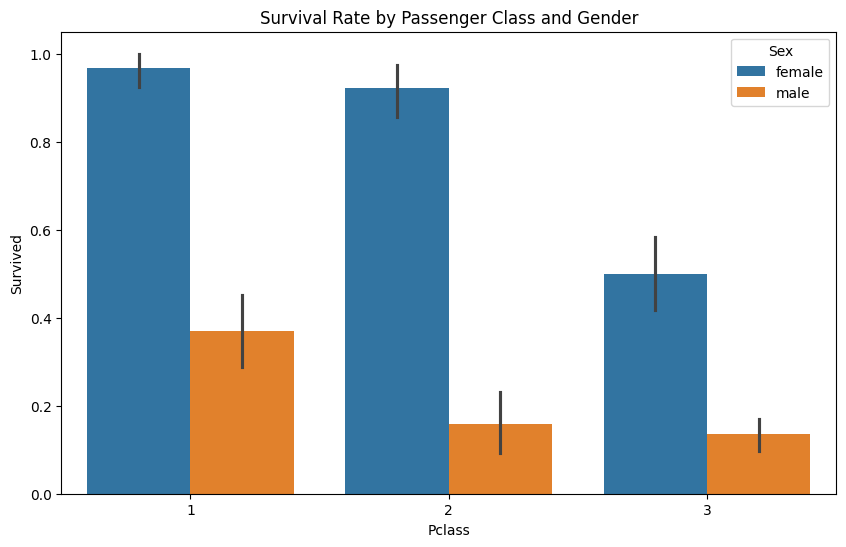

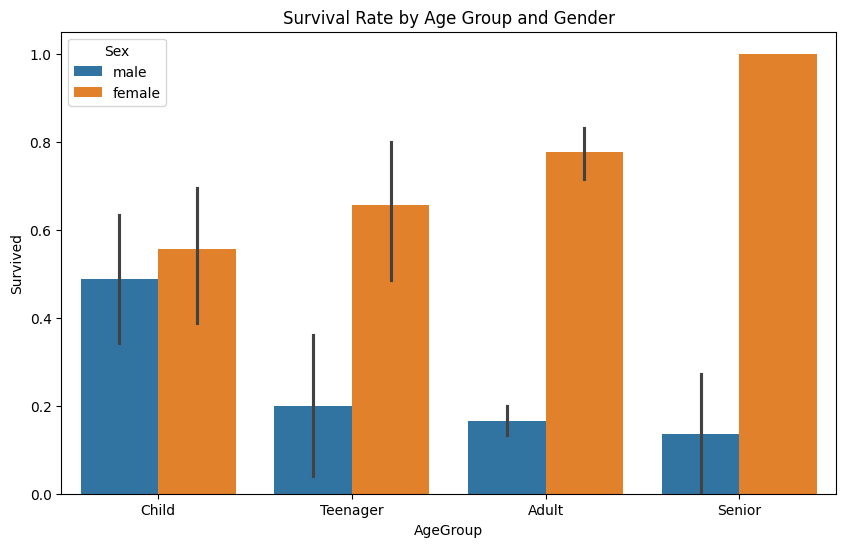

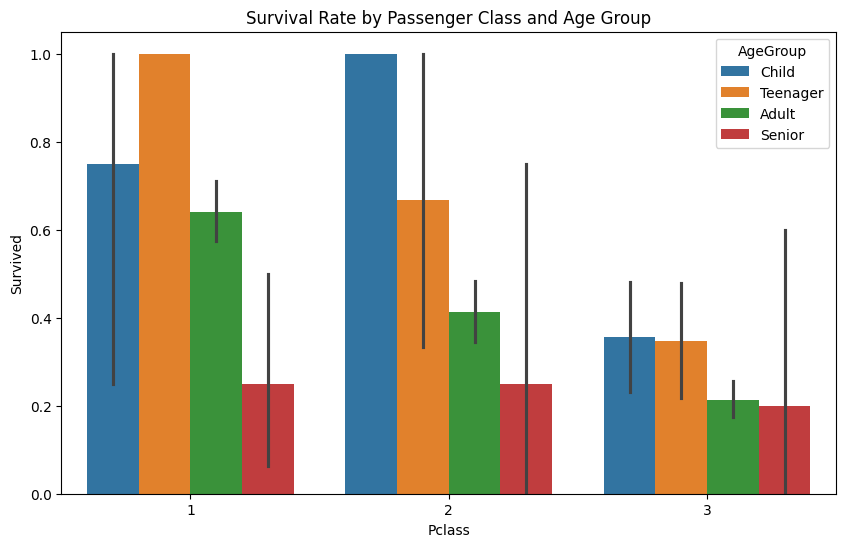

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Survival Rate by Passenger Class and Gender
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)
plt.title('Survival Rate by Passenger Class and Gender')
plt.show()

# 2. Survival Rate by Age Group and Gender
plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='Survived', hue='Sex', data=titanic_df)
plt.title('Survival Rate by Age Group and Gender')
plt.show()

# 3. Survival Rate by Passenger Class and Age Group
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', hue='AgeGroup', data=titanic_df)
plt.title('Survival Rate by Passenger Class and Age Group')
plt.show()

## Summary of Survival Rates by Age, Sex, and Class

Based on the analysis and visualizations:

*   **Gender is a primary factor**: Across all passenger classes and age groups, females had a significantly higher survival rate compared to males. This is a very strong trend observed throughout the data.
*   **Passenger Class significantly impacts survival**: Passengers in higher classes (1st and 2nd) generally had better survival rates than those in 3rd class. This difference is consistent across both genders and most age groups.
*   **Age plays a role, especially for children**: Children (AgeGroup 'Child') generally had higher survival rates than other age groups, particularly in 3rd class. This aligns with the "women and children first" protocol.
*   **Interaction of factors**: The visualizations highlight the combined effect of these factors. For example, while 3rd class passengers had the lowest overall survival rate, 3rd class *females* still had a considerably higher survival rate than 3rd class *males*. Similarly, even in the higher classes, there is a notable difference in survival rates between genders.
*   **Potential Behavioral Insights**: The stark differences in survival rates based on gender and class suggest that factors beyond just random chance were at play. The "women and children first" protocol likely influenced who was prioritized during evacuation. Socioeconomic status, as reflected by passenger class, also appears to be a major determinant of survival, possibly due to proximity to lifeboats or organized evacuation efforts. While age is a factor, the gender and class disparities are more pronounced.